# Sng Likelihood

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()

## Model

- $p(y \mid x) = \delta(y-\mathrm{sgn}(x))$
- infer gaussian $x$ prior $\mathcal{N}(r,v)$ from its sign 
$y = \mathrm{sgn}(x) \in \pm$
- $Z =  \int dx\, p(y\mid x) e^{-\frac{1}{2} a x^2 + b x} =  \int_{x \in \mathbb{R}_y} dx\, e^{-\frac{1}{2} a x^2 + b x}$

In [2]:
from tramp.likelihoods import SngLikelihood

## Posterior

In [3]:
def run_posterior(y, r, v):
    likelihood = SngLikelihood(np.array([y]))
    a, b = 1/v, r/v
    r_hat, v_hat = likelihood.compute_backward_posterior(a, b, y)
    return dict(a=a, b=b, r_hat=r_hat, v_hat=v_hat)

In [4]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)


result_handler = DataFrameResultHandler()
task = Task(run_posterior, y=[-1,+1], v = [0.5, 2], r = np.linspace(-10,10,101))
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()

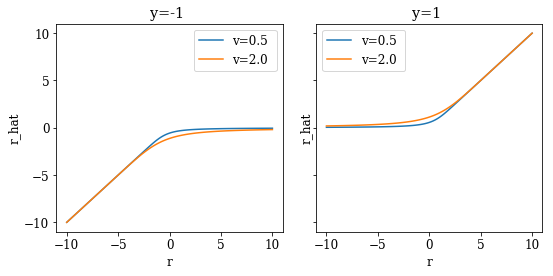

In [5]:
qplot(df, x="r", y="r_hat", color="v", column="y")

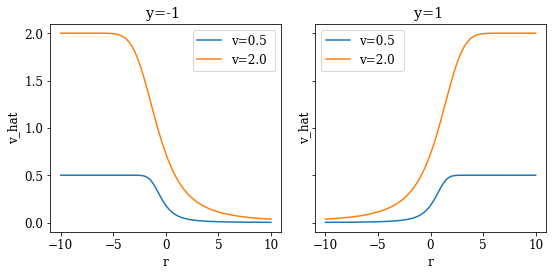

In [6]:
qplot(df, x="r", y="v_hat", color="v", column="y")

## Error function

Bad value : $a\tau - 1 < 0$ ie $ a = \frac{1}{v} < \frac{1}{\tau}$ ie $v > \tau$

$\tau$ supposed to be the second moment of $x$ so it makes sense !

In [7]:
def run_error(tau, v_scaled):
    v = v_scaled * tau
    a = 1/v
    if (a * tau - 1 < 0):
        return dict(a=a, v=v)
    s = np.sqrt(a * (a * tau - 1))
    likelihood = SngLikelihood(y=np.ones(1))
    error = likelihood.compute_backward_error(a, tau)
    error_scaled = error/tau
    return dict(a=a, v=v, s=s, error_scaled=error_scaled, error=error)

In [8]:
result_handler = DataFrameResultHandler()
task = Task(run_error, tau=[0.1, 1.0, 10.], v_scaled = np.linspace(0,1,51)[1:])
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()

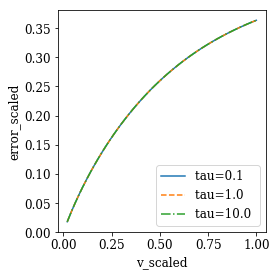

In [9]:
qplot(
    df, x="v_scaled", y="error_scaled", linestyle="tau"
)

## Numerical stability


In [10]:
# test initial condition a=tau
likelihood = SngLikelihood(y=np.ones(1))
for tau in [1., 2.]:
    print(f"tau={tau}")
    print(likelihood.compute_backward_posterior(az=tau, bz=0., y=+1))
    print(likelihood.compute_backward_error(az=tau+1e-15,tau=tau))
    print(likelihood.compute_backward_error(az=tau-1e-15,tau=tau))
    print()

tau=1.0
(0.79788456080286541, 0.36338022763241862)
0.36338022763241845
0.36338022763241895

tau=2.0
(0.56418958354775628, 0.18169011381620931)
0.32490205386673754
0.32490205386673776



## Checking $\frac{\mathcal{N}(x)}{\Phi(x)}$

In [11]:
from tramp.utils.misc import log_norm_cdf_prime, norm_cdf, norm_pdf
from scipy.stats import norm

def N_over_Phi(x):
    "Computes N(x)/Phi(x)"
    return norm_pdf(x)/norm_cdf(x)

In [12]:
x=np.linspace(-4,4,100)
assert np.allclose(norm_pdf(x), norm.pdf(x))
assert np.allclose(norm_cdf(x), norm.cdf(x))
assert np.allclose(N_over_Phi(x), log_norm_cdf_prime(x))

Naive implementation of  $\frac{\mathcal{N}(x)}{\Phi(x)}$ by `N_over_Phi` behaves badly for large negative x. The `log_norm_cdf_prime` implementation is numerically stable.

In [13]:
# divide by zero using naive N_over_phi
print(f"log_norm_cdf_prime(-10)={log_norm_cdf_prime(-10)}")
print(f"N_over_Phi(-10)={N_over_Phi(-10)}")

log_norm_cdf_prime(-10)=10.098093233962512
N_over_Phi(-10)=inf


/Users/antoinebaker/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


**Remark** $\frac{\mathcal{N}(x)}{\Phi(x)}$ close to reversed relu.

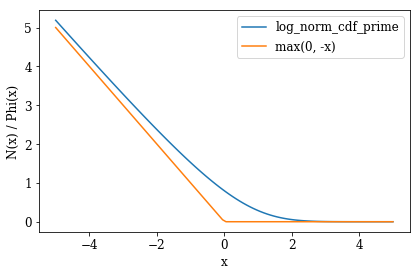

In [14]:
# reverse relu 
x=np.linspace(-5,5,100)
fig,ax=plt.subplots(1,1)
ax.plot(x, log_norm_cdf_prime(x),label="log_norm_cdf_prime")
ax.plot(x, np.maximum(0, -x),label="max(0, -x)")
ax.legend()
ax.set(xlabel="x",ylabel="N(x) / Phi(x)")
fig.tight_layout()